In [16]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

#### 1、 将原始《covtype.csv》数据集划分为训练集（70%）和测试集（30%）

In [29]:
# 读取数据集
parent_dir = os.path.abspath(os.pardir)
data = pd.read_csv(parent_dir + '/dataset/cov_type.csv')
data.iloc[:, -1] = data.iloc[:, -1] - 1

# 划分特征和标签
features = data.iloc[:, :-1]
label = data.iloc[:, -1]

# 划分数据集
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# 保存数据集
train_data.to_csv(parent_dir + '/dataset/cov_type_train.csv', index=False)
test_data.to_csv(parent_dir + '/dataset/cov_type_test.csv', index=False)

# 训练集和测试集样本量
print('Train data shape', train_data.shape)
print('Test data shape', test_data.shape)

Train data shape (406708, 55)
Test data shape (174304, 55)


#### 2、使用pandas读取《covtype_train.csv》和《covtype_test.csv》数据。

In [32]:
# 读取训练集和测试集
train_data = pd.read_csv(parent_dir + '/dataset/cov_type_train.csv')
test_data = pd.read_csv(parent_dir + '/dataset/cov_type_test.csv')

# 划分特征和标签
train_features = train_data.iloc[:, :-1]
train_labels = train_data.iloc[:, -1]
test_features = test_data.iloc[:, :-1]
test_labels = test_data.iloc[:, -1]
print('test label shape', test_labels.shape)

test label shape (174304,)


#### 3、利用StandardScaler获得训练集特征的均值向量u和标准差向量s

In [7]:
# 创建StandardScaler对象
scaler = StandardScaler()

# 使用训练数据拟合Scaler
scaler.fit(train_features)

print("训练集特征的均值向量u = ", scaler.mean_)
print(("标准差向量s = ", scaler.var_))

NameError: name 'train_features' is not defined

#### 4、 利用u和s对训练集和测试集特征进行归一化

In [8]:
# 对训练集特征进行归一化
train_features = scaler.transform(train_features)

# 对测试集特征进行归一化
test_features = scaler.transform(test_features)

print("归一化后，训练集特征均值向量u = ", np.mean(train_features, axis=0))
print("归一化后，训练集特征标准差向量s = ", np.std(train_features, axis=0))
print("归一化后，测试集特征均值向量u = ", np.mean(test_features, axis=0))
print("归一化后，测试集特征均值向量u = ", np.std(test_features, axis=0))

NameError: name 'train_features' is not defined

#### 5、保留10%的训练集作为验证集

In [9]:
train_features, valid_features, train_labels, valid_labels = train_test_split(train_features, train_labels,
                                                                              test_size=0.1, random_state=42)
print("训练集特征矩阵维度：", train_features.shape, "训练集标签矩阵维度：", train_labels.shape)
print("验证集特征矩阵维度：", valid_features.shape, "验证集标签矩阵维度：", valid_labels.shape)
print("测试集特征矩阵维度：", test_features.shape, "测试集标签矩阵维度：", test_labels.shape)

NameError: name 'train_features' is not defined

#### 6、定义分类预测神经网络模型

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# 初始化模型
net = Net(input_size=54, hidden_size=50, num_classes=7)

# 打印模型结构信息及参数量
print("模型结构信息: ", net)
print("模型参数量: ", sum(p.numel() for p in net.parameters()))

模型结构信息:  Net(
  (fc1): Linear(in_features=54, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=7, bias=True)
  (relu): ReLU()
)
模型参数量:  3107


#### 7、定义损失函数和优化器

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

#### 8、将所有数据转换为Tensor

In [12]:
# 将数据转换为PyTorch张量
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64)
valid_features_tensor = torch.tensor(valid_features, dtype=torch.float32)
valid_labels_tensor = torch.tensor(valid_labels, dtype=torch.int64)

# 创建数据加载器
train_data = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

NameError: name 'train_features' is not defined

#### 9、训练模型，并保存验证集上准确率最有的预测模型

In [13]:
best_model = None
best_acc = 0

# 初始化准确率列表
train_acc_list = []
valid_acc_list = []

# 训练模型
for epoch in range(20):
    running_loss = 0.0
    correct_train = 0.0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        # 获得输入数据
        inputs, labels = data
        # 梯度清零
        optimizer.zero_grad()
        # 前向传播 + 反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # 计算训练集准确率
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)
    print("======= Epoch %d =======" % (epoch + 1))
    print("Train Accuracy: %.2f %% " % train_acc)

    # 使用验证集评估模型
    with torch.no_grad():
        valid_outputs = net(valid_features_tensor)
        _, predicted = torch.max(valid_outputs, 1)

        # 计算验证集准确率
        correct_valid = (predicted == valid_labels_tensor).sum().item()
        valid_acc = 100 * correct_valid / valid_labels_tensor.size(0)
        print("Validation Accuracy: %.2f %% " % valid_acc)
        valid_acc_list.append(valid_acc)

        # 保存最佳验证集上Accuracy最高的模型
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = net
print("Finished Training")

NameError: name 'train_loader' is not defined

#### 10、绘制训练集和验证集的准确率变化曲线

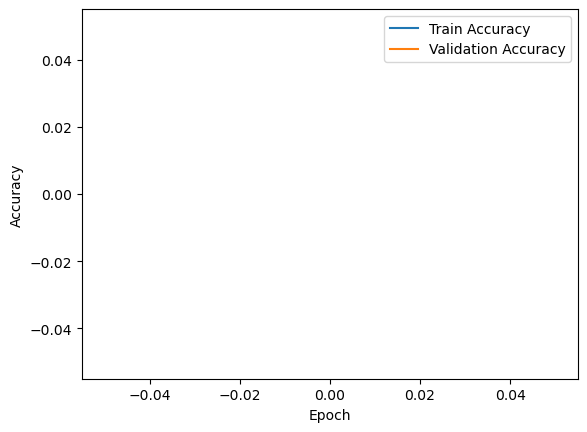

In [14]:
epoch = list(range(1, len(train_acc_list) + 1))
plt.plot(epoch, train_acc_list, label='Train Accuracy')
plt.plot(epoch, valid_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 11、对测试集样本点进行预测，计算预测准确率。

In [ ]:
with torch.no_grad():
    test_outputs = best_model(torch.tensor(test_features, dtype=torch.float32))
    _, predicted = torch.max(test_outputs, 1)
    correct_test = (predicted == torch.tensor(test_labels, dtype=torch.int64)).sum().item()
    print("Test Accuracy: %d %%" % (100 * correct_test / test_labels.size))